In [210]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
path = "./stitching_images/"

In [211]:
print(cv2.__version__)
plt.rcParams.update({'font.size': 17})
plt.rcParams['figure.figsize'] = 20, 20

3.3.0


## 2 Image Stitching
### 2.1
#### 1)

In [227]:
# We load images and remove random white border pixels
img1 = cv2.imread(path + "1Hill.jpg")[1:, 1:]
img2 = cv2.imread(path + "2Hill.jpg")[1:, 1:]
img3 = cv2.imread(path + "3Hill.jpg")[1:, 1:]

In [228]:
def sift(img, plot=True):
    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints, descriptors = sift.detectAndCompute(img, None)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


    # display
    if plot:
        plt.figure(figsize=(10,10))
        plt.subplot(121), plt.imshow(img)
        plt.title("Input Image", fontsize=12), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img_disp)
        plt.title("SIFT Features", fontsize=12), plt.xticks([]), plt.yticks([])
        plt.show()

        # num of SIFT keypoints
        print('Num keypoints: '+ str(len(keypoints)))
    return (keypoints, descriptors)

1Hill: 

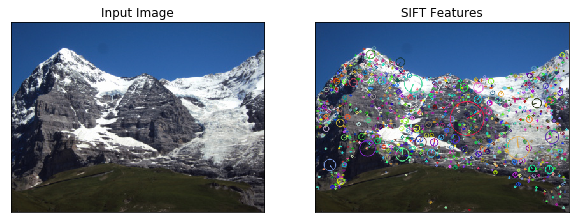

Num keypoints: 1252


2Hill: 

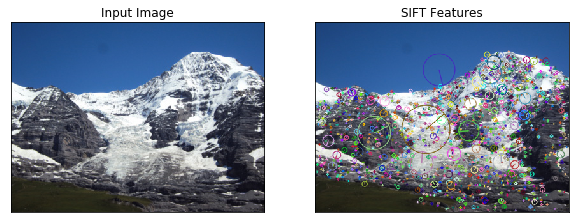

Num keypoints: 1468


In [229]:
print("1Hill: ", end=''),
keypoints1, descriptors1 = sift(img1)
print('\n')
print("2Hill: ", end=''),
keypoints2, descriptors2 = sift(img2)

#### 2)

In [230]:
import enum

class DetectorType(enum.Enum): 
    SIFT = 1
    SURF = 2

def match_img(img1, img2, features, plot=True):
    if features == DetectorType.SIFT:
        print("SIFT selected")
        kp1, des1 = sift(img1, False)
        kp2, des2 = sift(img2, False)
    elif features == DetectorType.SURF:
        print("SURF selected")
        kp1, des1 = surf(img1, False)
        kp2, des2 = surf(img2, False)
    else:
        return "Error please enter either SIFT or SURF for feature detection"
    
    bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    
    img3 = cv2.drawMatches(img1,kp1,img2,kp2, matches[:20], img1, flags=2)
    
    if plot:
        plt.figure(figsize=(20,20))
        plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
        plt.show()
    return matches

SIFT selected


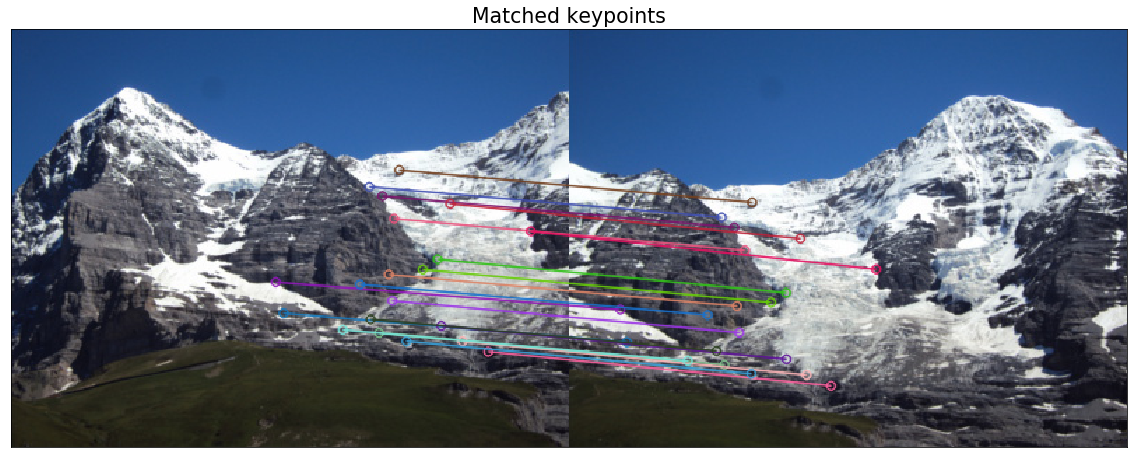

1252


In [231]:
matches = match_img(img1, img2, DetectorType.SIFT)
print(len(matches))

In [232]:
def crop_image(image, threshold=0):
    """
    From: 
    https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv

    """
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

#### 3)

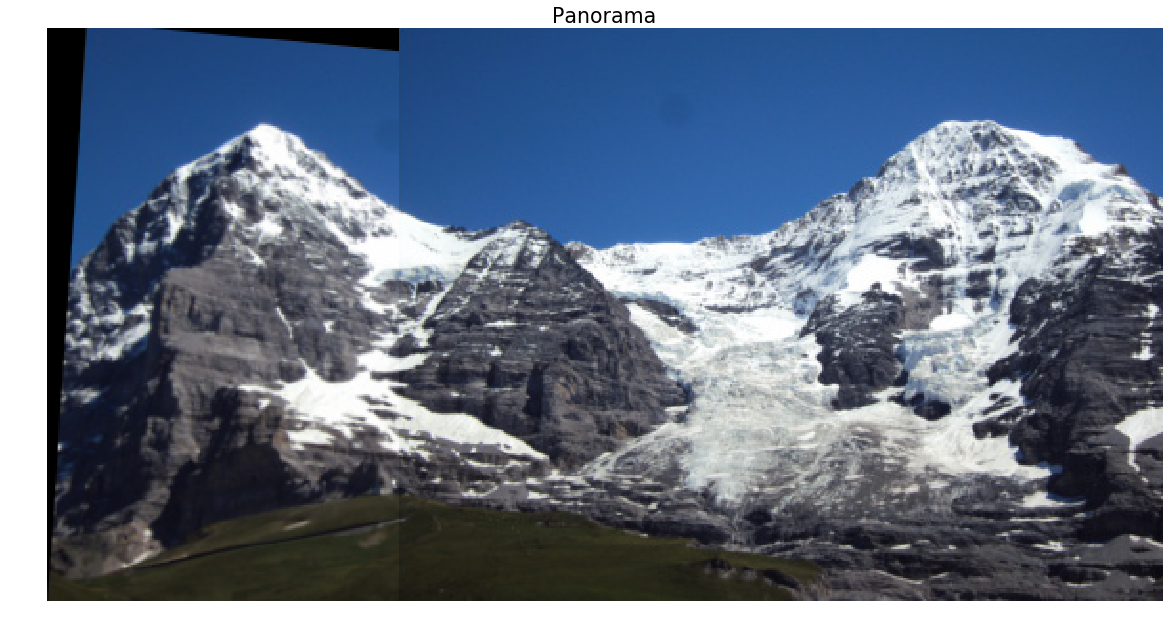

In [233]:
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
# GoodMatches = GoodMatches[:-1]
mpr = np.float32([keypoints2[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints1[i].pt for (__, i) in GoodMatches])

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(mpr)):
    mpr[i][0] += img2.shape[1]

h, mask = cv2.findHomography(mpl, mpr, cv2.RANSAC, 5)

# Use homography
height, width, channels = img1.shape
height2, width2, channels2 = img2.shape
height_factor = 25 # used to offset cropping of image
img1warp = cv2.warpPerspective(img1, h, (width + width2, height2))
img12 = img1warp.copy()
img12[:height,width:,:] = img2

plt.imshow(cv2.cvtColor(crop_image(img12), cv2.COLOR_BGR2RGB))
plt.title("Panorama"), plt.axis('off')
plt.show()

img2 shape:  (274, 578, 3)


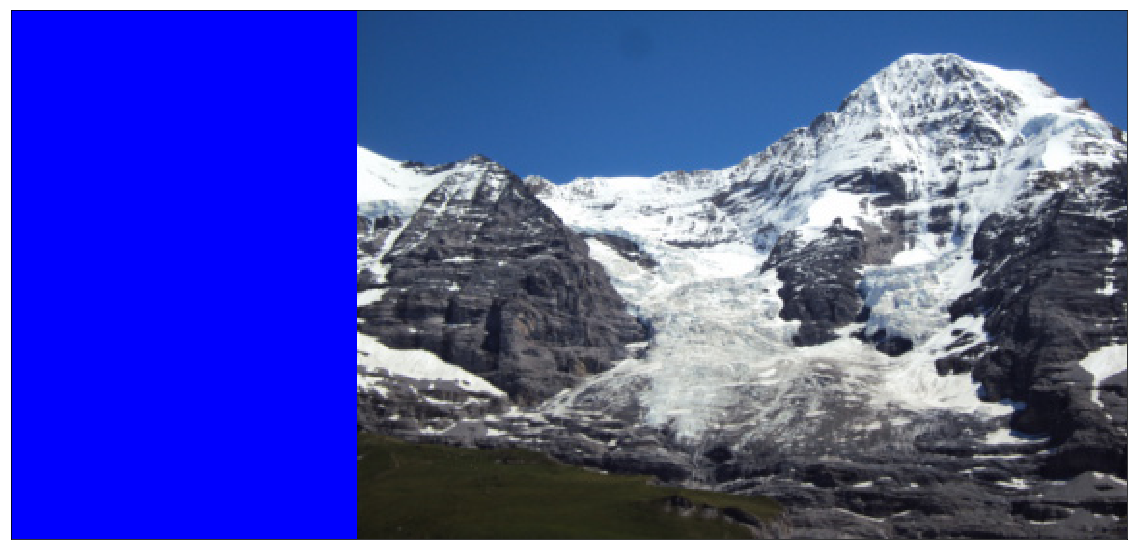

img1warp shape:  (274, 578, 3)


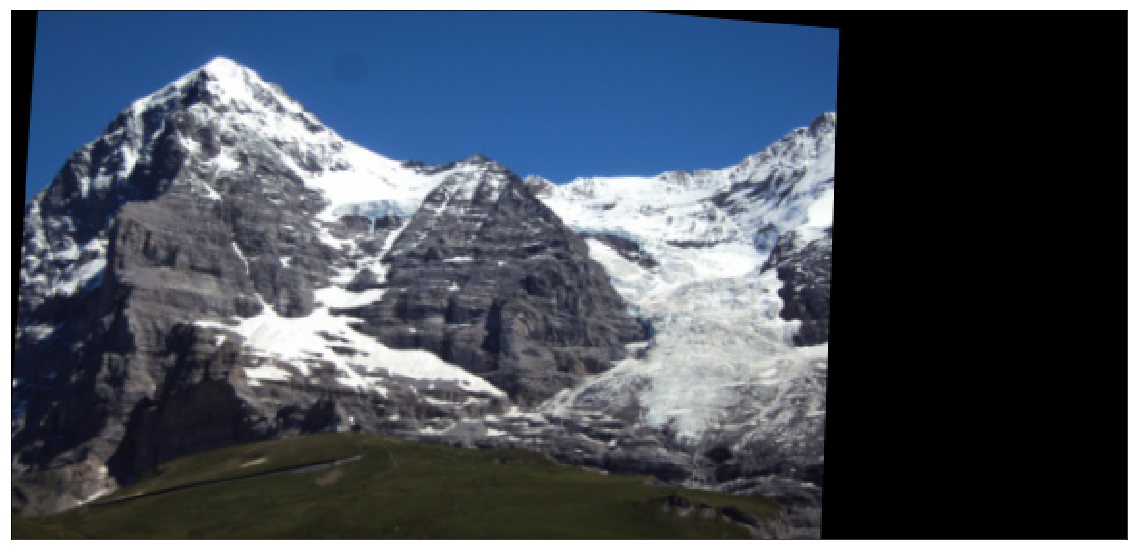

In [60]:
img2 = cv2.imread(path + "2Hill.jpg")[1:, 1:]
img2_pad = cv2.copyMakeBorder(img2, 0, 0, img1.shape[1], 0, cv2.BORDER_CONSTANT,value=255)
img1blend = img1warp.copy()

img2_pad = img2_pad[25:, 220:]
print("img2 shape: ", img2_pad.shape)
img1blend = img1blend[25:, 220:]
plt.imshow(cv2.cvtColor(img2_pad, cv2.COLOR_BGR2RGB)), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(cv2.cvtColor(img1blend, cv2.COLOR_BGR2RGB)), plt.xticks([]), plt.yticks([]) 
print("img1warp shape: ", img1blend.shape)
plt.show()

#### 4) Pyramid Blending


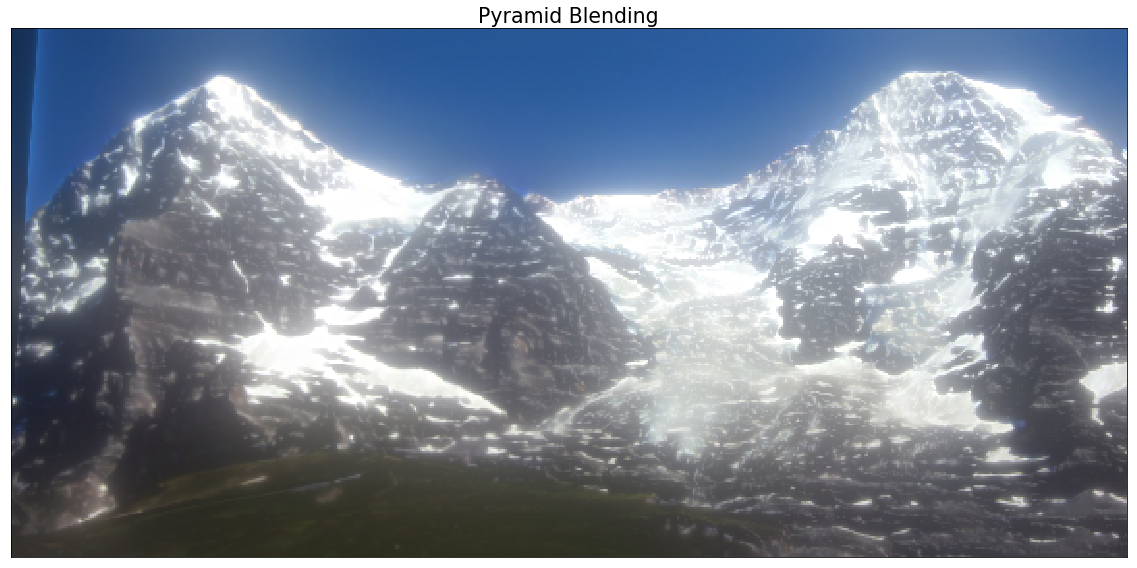

In [235]:
# parameters
g_size = 255  # gaussian mask blur size
depth = 6  # pyramid depth size

A = img1blend.copy()
B = img2_pad.copy()

""" PYRAMID BLENDING """
row, col, dpt = A.shape
# generate Gaussian pyramid for imgA
G = A.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Gaussian pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((A.shape[1], A.shape[0]))
# create mask
mask[:, round(A.shape[1]/2):] = 1
# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)
# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i

    # Now blend
    lp = (1-GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1)) * la + \
         GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs, dstsize=(LP_mask[i].shape[1], LP_mask[i].shape[0]))  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask,  dstsize=(LP_mask[i].shape[1], LP_mask[i].shape[0]))  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

# display results
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(rs, cv2.COLOR_RGB2BGR))
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.show()

img12 = rs

#### 1) SURF Features

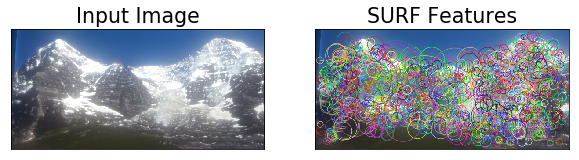

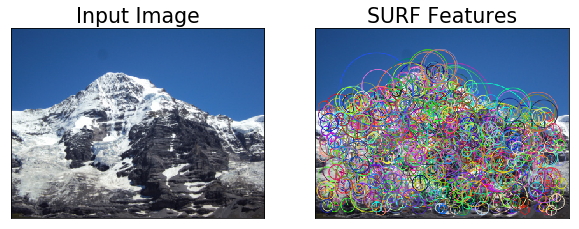

In [236]:
def sift(img, plot=True):
    # copy image
    img_disp = img.copy()
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints, descriptors = sift.detectAndCompute(img, None)

    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


    # display
    if plot:
        plt.figure(figsize=(10,10))
        plt.subplot(121), plt.imshow(img)
        plt.title("Input Image", fontsize=12), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img_disp)
        plt.title("SIFT Features", fontsize=12), plt.xticks([]), plt.yticks([])
        plt.show()

        # num of SIFT keypoints
        print('Num keypoints: '+ str(len(keypoints)))
    return (keypoints, descriptors)

def surf(img, plot=True):
    # copy image
    img_disp = img.copy()
    # convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

    # create SURF object
    surf = cv2.xfeatures2d.SURF_create()

    # detect SURF features
    keypoints, descriptors = surf.detectAndCompute(img, None)

    # draw keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    if plot:
        # display images
        plt.figure(figsize=(10,10))
        plt.subplot(121), plt.imshow(img)
        plt.title("Input Image"), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img_disp)
        plt.title("SURF Features"), plt.xticks([]), plt.yticks([])
        plt.show()
    return (keypoints, descriptors)
    
    
keypoints12, descriptors12 = surf(img12)
keypoints3, descriptors3 = surf(img3)

#### 2) Best 20 Matches

SURF selected


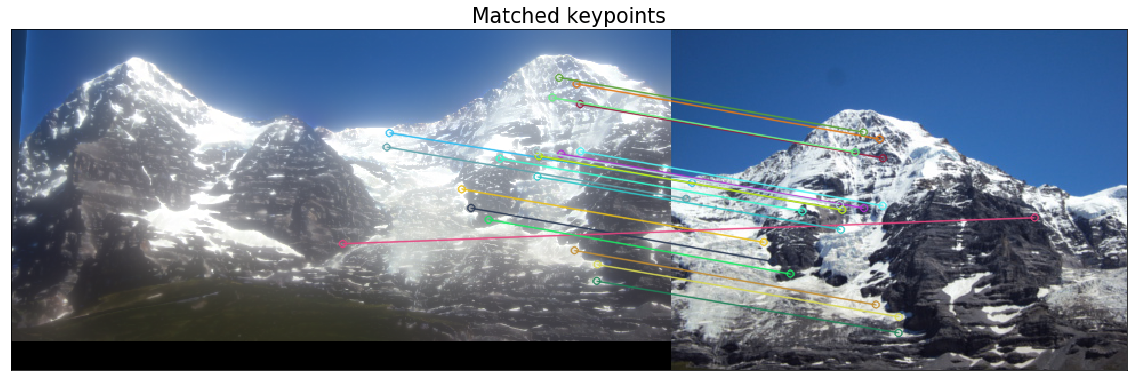

Wall time: 704 ms


In [82]:
matches = match_img(img12, img3, DetectorType.SURF, True);
matches = matches[:20]

#### 3) Homography

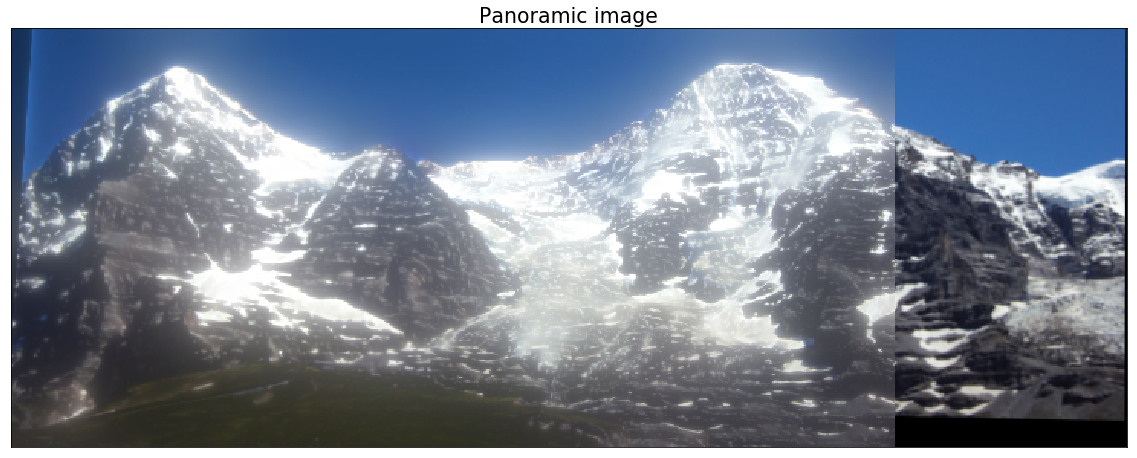

In [77]:
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints3[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints12[i].pt for (__, i) in GoodMatches])


h, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(img3, h, (img3.shape[1]+img12.shape[1],img3.shape[0]))
wimg[:img12.shape[0],:img12.shape[1],:] = img12

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(crop_image(wimg), cv2.COLOR_BGR2RGB))
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

#### 4) Blending

In [ ]:
##################
# IMAGE BLENDING #
##################

# read images
A = img12
B = cv2.copyMakeBorder(img3, 0, 0, (-img3.shape[1] + img12.shape[1]), 0, cv2.BORDER_CONSTANT,value=255)
B = B[B.shape[0] - A.shape[0]:]

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, round(A.shape[1]/2), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * A + alpha.reshape(1,-1,1)*B
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(crop_image(wimg), cv2.COLOR_RGB2BGR))
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(I_blend, cv2.COLOR_RGB2BGR))
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

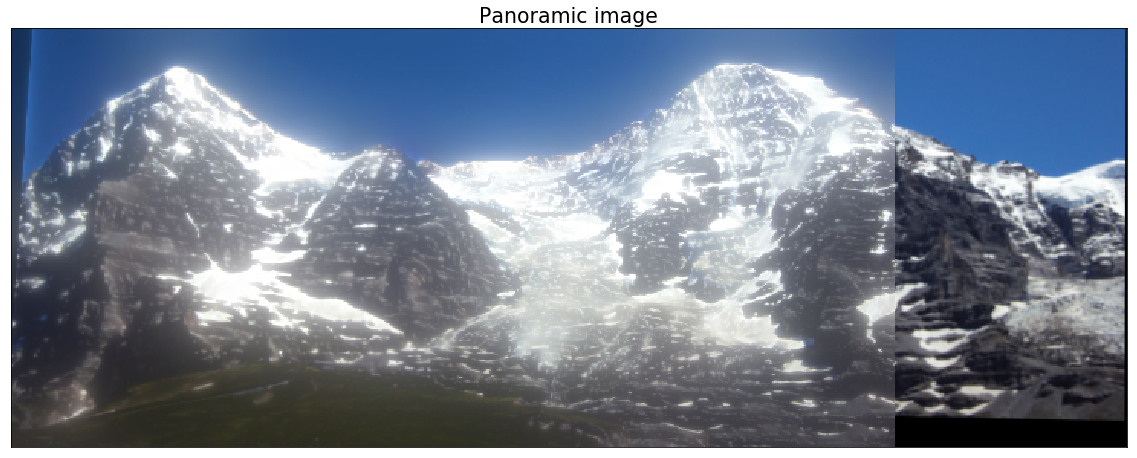

In [61]:
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints3[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints12[i].pt for (__, i) in GoodMatches])


h, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(img3, h, (img3.shape[1]+img12.shape[1],img3.shape[0]))
wimg[:img12.shape[0],:img12.shape[1],:] = img12

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(crop_image(wimg), cv2.COLOR_BGR2RGB))
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

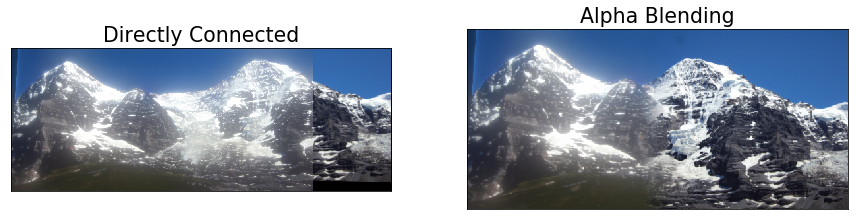

In [75]:
##################
# IMAGE BLENDING #
##################

# read images
A = img12
B = cv2.copyMakeBorder(img3, 0, 0, (-img3.shape[1] + img12.shape[1]), 0, cv2.BORDER_CONSTANT,value=255)
B = B[B.shape[0] - A.shape[0]:]

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, round(A.shape[1]/2), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * A + alpha.reshape(1,-1,1)*B
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(crop_image(wimg), cv2.COLOR_RGB2BGR))
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(I_blend, cv2.COLOR_RGB2BGR))
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

## 2.2 Reasoning Questions

### 1. What are the differences between SIFT and SURF, in terms of speed, number of keypoints and density?
We know that SURF is a fast approximation of SIFT. So naturally, we assume that SURF is faster than SIFT. SURF uses the Fast-Hessian matrix which is faster in computation compared to the DoG or Laplacian method used by the SIFT method. This speed difference is proven by our statistics below. SIFT  generates a larger number of keypoints than SURF because of the extra computation accuracy and lack of approximations taken to complete the detection. This can also be seen my our statistics below. This in turn means that SIFT generates a higher density of keypoints. However, for our purposes of object matching this does not make a difference as we only select the top matches. 

In [96]:
import time

sift = cv2.xfeatures2d.SIFT_create()

surf = cv2.xfeatures2d.SURF_create()


startSurf = time.time()
keypoints, descriptors = surf.detectAndCompute(img2, None)
endSurf = time.time()
print("SURF: ", endSurf - startSurf)
print("len(keypoints): ", len(keypoints))
print("len(descriptors): ", len(descriptors))
print('\n')

startSift = time.time()
keypoints, descriptors = sift.detectAndCompute(img2, None)
endSift = time.time()
print("SIFT: ", endSift - startSift)
print("len(keypoints): ", len(keypoints))
print("len(descriptors): ", len(descriptors))

SURF:  0.07997775077819824
len(keypoints):  952
len(descriptors):  952


SIFT:  0.09913969039916992
len(keypoints):  1491
len(descriptors):  1491


### 2. Linear Blending vs Laplacian Pyramid
Linear blending can sometimes cause ghosting and the window size needs to be selected in a way that is specific to the blending effect desired. In this manner, "feathering" or linear blending doesn't always work and cause undesired distortions in the image. The size of the window needs to be selected to avoid both seams and ghosting. 

Pyramid blending smoothes low frequency exposure variation and retains sharp transitions. This is also computationally much slower than the linear blending technique but provides better results with less hand tuning needed. 

### 3. Random Subset of Points
If a random subset of matching keypoints is used to find homography it could result is a final image that is less accurate than if the best matches are used. This is because sometimes the matched keypoints will be inaccurate or not representative of the general orientation of the image so you receive better results by taking the best matches rather a random subset of matches. 

### 4. Increasing Number of Pairs
It is persumed that increasing the number of matches used in homography would increase the accuracy of the homography. However, in our case, the features we find could be false positives and increasing the number of pairs would create incorrect matches. This is why in our implementation we take the top 20 matches instead of all the matches. 